In [85]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
        print("Setting GPU Memory Growth...")
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

import time
import datetime

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from plot_keras_history import plot_history
import sklearn.metrics as metrics
import os as os

import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.python.client import device_lib

import kerastuner as kt
from kerastuner.tuners import RandomSearch, BayesianOptimization

from tcn import TCN


print("TF version:", tf.__version__)
print("KT version:", kt.__version__)
print("Panda version:", pd.__version__)

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print("Physical devices: ", tf.config.list_physical_devices())
# Se va a habilitar la dedicacion dinamica de memoria para que la GPU vaya asignando recursos al proceso conforme los vaya necesitando

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
#print(tf.config.list_physical_devices('GPU'))
print("Build with CUDA: ", tf.test.is_built_with_cuda())

# Number of measurements to predict
numPredictions = 20

# Number of best models
numBestModels = 1 

# Validation set percentage
val_size = 0.3

# Batch size
batch = 1024

# Filters parameters
minFilters = 32
maxFilters = 128
stepsFilters = 32
defaultFilters = 32

# Filters parameters
minKernels = 2
maxKernels = 5
stepsKernels = 1
defaultKernels = 3

# Filters parameters
dilations = [1, 2, 4, 8, 16]

# Layers parameters
minLayers = 1
maxLayers = 10
defaultLayers = 3

# Dropout Parameters
minDropout = 0
maxDropout = 0.33
defaultDropout = 0.25

# Establish loss measure
loss = "mean_absolute_error"

# Learning rate
learningRate = [0.0, 1e-2, 1e-3, 1e-4]

# Model metrics
modelMetrics = [keras.metrics.MAE, tf.keras.metrics.RootMeanSquaredError(name = 'rmse')]

# Optimizer objetive: error percetange with the validation set 
objective = kt.Objective('val_mean_absolute_error', 'min')

# Maximum model trials and executions
trials = 2
executions = 5

Setting GPU Memory Growth...


c:\Users\hecto\.conda\envs\myenv\lib\site-packages\tensorflow_core\python\client\session.py:1752: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


TF version: 2.1.0
KT version: 1.0.1
Panda version: 1.1.5
Physical devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Default GPU Device: /device:GPU:0
Num GPUs Available:  1
Build with CUDA:  True


In [86]:
# X = pd.read_csv("C:/Users/hecto/Documents/Master/TFM/tfm-renewable-energy-deep-learning/data/training/2015_PV_W20_H20.csv",
#                        delimiter=";")

# xTest = pd.read_csv("C:/Users/hecto/Documents/Master/TFM/tfm-renewable-energy-deep-learning/data/test/2016_PV_W20_H20.csv",
#                    delimiter=";")

X = pd.read_csv("C:/Users/hecto/Documents/Master/TFM/tfm-renewable-energy-deep-learning/data/training/2015_Weather_W7.csv",
                       delimiter=",")

xTest = pd.read_csv("C:/Users/hecto/Documents/Master/TFM/tfm-renewable-energy-deep-learning/data/test/2016_Weather_W7.csv",
                   delimiter=",")

print(X)
print(xTest)

     min_temp_d1  max_temp_d1  rainfall_d1  sun_hours_d1  max_wind_speed_d1  \
0       0.919431     0.699029     0.001095      0.774436           0.261538   
1       0.909953     0.621359     0.006572      0.315789           0.369231   
2       0.744076     0.684466     0.092004      0.902256           0.230769   
3       0.777251     0.582524     0.000000      0.285714           0.138462   
4       0.763033     0.650485     0.118291      0.909774           0.338462   
..           ...          ...          ...           ...                ...   
354     0.767773     0.699029     0.000000      0.721805           0.200000   
355     0.729858     0.703883     0.000000      0.902256           0.261538   
356     0.729858     0.582524     0.017525      0.097744           0.261538   
357     0.677725     0.597087     0.050383      0.774436           0.230769   
358     0.644550     0.771845     0.002191      0.969925           0.200000   

     temp_9_d1  Rel_hum_9_d1  cloud_cover_d1  wind_

In [87]:
# Epochs
epchs = 1000

W=20
H=20
PV_index = 14

projectNameRS = "Weather_W7-tcn-rs"
projectNameBO = "Weather_W7-tcn-bo"

In [88]:
# Preprocessing for W type files:

# Filter for PV data
X = X.iloc[:, ::PV_index]
xTest = xTest.iloc[:, ::PV_index]

numPredictions = len(X.columns)

# Reset column names
new_column_names = [f'PV_{i+1}' for i in range(numPredictions)]
X.columns = new_column_names
xTest.columns = new_column_names

Y = pd.DataFrame.copy(X)
yTest = pd.DataFrame.copy(xTest)

# Create Y from taking next day data
Y = Y.drop(0)
Y = Y.reset_index(drop = True)
Y.loc[len(Y)] = np.zeros(numPredictions)

yTest = yTest.drop(0)
yTest = yTest.reset_index(drop = True)
yTest.loc[len(yTest)] = np.zeros(numPredictions)

print(X)
print(yTest)

         PV_1      PV_2      PV_3      PV_4      PV_5      PV_6      PV_7
0    0.919431  0.909953  0.744076  0.777251  0.763033  0.720379  0.682464
1    0.909953  0.744076  0.777251  0.763033  0.720379  0.682464  0.729858
2    0.744076  0.777251  0.763033  0.720379  0.682464  0.729858  0.791469
3    0.777251  0.763033  0.720379  0.682464  0.729858  0.791469  0.853081
4    0.763033  0.720379  0.682464  0.729858  0.791469  0.853081  0.810427
..        ...       ...       ...       ...       ...       ...       ...
354  0.767773  0.729858  0.729858  0.677725  0.644550  0.862559  0.696682
355  0.729858  0.729858  0.677725  0.644550  0.862559  0.696682  0.620853
356  0.729858  0.677725  0.644550  0.862559  0.696682  0.620853  0.649289
357  0.677725  0.644550  0.862559  0.696682  0.620853  0.649289  0.663507
358  0.644550  0.862559  0.696682  0.620853  0.649289  0.663507  0.649289

[359 rows x 7 columns]
         PV_1      PV_2      PV_3      PV_4      PV_5      PV_6      PV_7
0    0.739336 

In [89]:
# # Old Data preprocessing: each row will contain the 20 measures for each day , and the 10 measures for the following day
# # X = pd.DataFrame(np.array(training).reshape(-1, W))
# Y = pd.DataFrame.copy(X)
# yTest = pd.DataFrame.copy(xTest)

# Y.columns = ["col_{}".format(i) for i in range(W+1, (2*W)+1)]
# Y = Y.drop(0)
# Y = Y.reset_index(drop = True)
# Y.loc[len(Y)] = np.zeros(numPredictions)

# # Last row is deleted because it is the one used for the real prediction, 
# # it is not useful for the training of the model. 
# X.drop(X.tail(1).index, inplace = True)
# Y.drop(Y.tail(1).index, inplace = True)

# print("X Preproccessed shape: ", X.shape)
# print("Y Preproccessed shape: ", Y.shape)
# print("---------------------------------------------")

# #  Uncomment in order to normalize data
# # Data Normalization
# # scaler = MinMaxScaler()
# # X = pd.DataFrame(scaler.fit_transform(X), columns=["col_{}".format(i) for i in range(1, 21)])
# # Y = pd.DataFrame(scaler.fit_transform(Y), columns=["col_{}".format(i) for i in range(21, 41)])

In [90]:
dfPreproccessed = pd.concat([X, Y], axis = 1)

print("DataFrame Preproccessed:")
print(dfPreproccessed)
print("---------------------------------------------")

# Split the data into training and validation sets
xTrain, xVal, yTrain, yVal = train_test_split(X, 
                                            Y, 
                                            test_size = val_size, 
                                            random_state = 0, 
                                            shuffle=False)

# Show subsets shapes
print("Shapes:")
print("xTrain:\t"+str(xTrain.shape))
print("yTrain:\t"+str(yTrain.shape))
print("xVal:\t"+str(xVal.shape))
print("yVal:\t"+str(yVal.shape))
print("xTest:\t"+str(xTest.shape))
print("yTest:\t"+str(yTest.shape))
print("---------------------------------------------")

DataFrame Preproccessed:
         PV_1      PV_2      PV_3      PV_4      PV_5      PV_6      PV_7  \
0    0.919431  0.909953  0.744076  0.777251  0.763033  0.720379  0.682464   
1    0.909953  0.744076  0.777251  0.763033  0.720379  0.682464  0.729858   
2    0.744076  0.777251  0.763033  0.720379  0.682464  0.729858  0.791469   
3    0.777251  0.763033  0.720379  0.682464  0.729858  0.791469  0.853081   
4    0.763033  0.720379  0.682464  0.729858  0.791469  0.853081  0.810427   
..        ...       ...       ...       ...       ...       ...       ...   
354  0.767773  0.729858  0.729858  0.677725  0.644550  0.862559  0.696682   
355  0.729858  0.729858  0.677725  0.644550  0.862559  0.696682  0.620853   
356  0.729858  0.677725  0.644550  0.862559  0.696682  0.620853  0.649289   
357  0.677725  0.644550  0.862559  0.696682  0.620853  0.649289  0.663507   
358  0.644550  0.862559  0.696682  0.620853  0.649289  0.663507  0.649289   

         PV_1      PV_2      PV_3      PV_4      P

In [91]:

# Model definition:
with tf.device('/gpu:0'): 
    
    def build_model(hp): 

        model = Sequential()
        
        # First layer: TCN. Number of nb_filters, kernel_size, and dilations optimization.
        model.add(TCN(nb_filters = hp.Int('filters', 
                                    min_value = minFilters,
                                    max_value = maxFilters, 
                                    step = stepsFilters,
                                    default = defaultFilters),
                        kernel_size = hp.Int('kernel_size', 
                                    min_value = minKernels,
                                    max_value = maxKernels, 
                                    step = stepsKernels,
                                    default = defaultKernels),
                        dilations = dilations,
                        return_sequences = False, 
                        input_shape = (xTrain.shape[1], 1)))

        # Second layer: Dropout with percetange optimization
        model.add(
            Dropout(hp.Float('dropout', 
                            min_value = minDropout,
                            max_value = maxDropout,
                            default = defaultDropout)))
        
        # Last layer:
        model.add(Dense(numPredictions))

        print("Summary: ")
        model.summary()

        # # Set Epsilon to 1, in order to fix huge MAPE values.
        # keras.backend.set_epsilon(1)

        # Model compilation: learning rate optimization
        model.compile(loss = loss,
                    optimizer = keras.optimizers.Adam(hp.Choice('learning_rate', 
                                                                values = learningRate)),
                    metrics = modelMetrics)

        return model

In [92]:
# Model training:
with tf.device('/gpu:0'): 
    # Create optimizer
    tcnOptimizer = RandomSearch(build_model, 
                                objective = objective,
                                max_trials = trials, 
                                executions_per_trial = executions,
                                project_name = projectNameRS,
                                overwrite=True)
    
    # Search space summary
    tcnOptimizer.search_space_summary()

    # Search execution with epochs
    initialTime = time.time()
    tcnOptimizer.search(x = np.reshape(xTrain.values, (xTrain.shape[0], xTrain.shape[1], 1)),
                        y = yTrain, 
                        epochs = epchs,
                        batch_size = batch,
                        validation_data=(np.reshape(xVal.values, (xVal.shape[0], xVal.shape[1], 1)), yVal))
    finalTime = time.time()

    # Results summary
    tcnOptimizer.results_summary()

    # Get best model generated
    model = tcnOptimizer.get_best_models(num_models = numBestModels)[0]

    # Model training with epochs 
    history = model.fit(
                np.reshape(xTrain.values, (xTrain.shape[0], xTrain.shape[1], 1)),
                yTrain,
                epochs = epchs,
                batch_size = batch,
                validation_data=(np.reshape(xVal.values, (xVal.shape[0], xVal.shape[1], 1)), yVal))

    # Show model info
    print("Tiempo de entrenamiento (en segundos):\t"+str(finalTime - initialTime))
    print("Tiempo de entrenamiento (en horas):\t"+str((finalTime - initialTime)/3600))
    print(history.history.keys())
    print(model.history.history)
    print(model.history.params)

Summary: 
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn (TCN)                    (None, 32)                28128     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 7)                 231       
Total params: 28,359
Trainable params: 28,359
Non-trainable params: 0
_________________________________________________________________


Summary: 
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn (TCN)                    (None, 96)                250272    
_________________________________________________________________
dropout (Dropout)            (None, 96)                0         
_________________________________________________________________
dense (Dense)                (None, 7)                 679       
Total params: 250,951
Trainable params: 250,951
Non-trainable params: 0
_________________________________________________________________
Train on 251 samples, validate on 108 samples
Epoch 1/1000
251/251 [==============================] - 2s 8ms/sample - loss: 1.7448 - mean_absolute_error: 1.7448 - rmse: 2.2397 - val_loss: 13.2661 - val_mean_absolute_error: 13.2661 - val_rmse: 14.2357
Epoch 2/1000
251/251 [==============================] - 0s 237us/sample - loss: 11.2202 - mean_absolute_error: 11.2202 

Summary: 
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn (TCN)                    (None, 32)                28128     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 7)                 231       
Total params: 28,359
Trainable params: 28,359
Non-trainable params: 0
_________________________________________________________________
Train on 251 samples, validate on 108 samples
Epoch 1/1000
251/251 [==============================] - 2s 7ms/sample - loss: 2.0368 - mean_absolute_error: 2.0368 - rmse: 2.7937 - val_loss: 2.2989 - val_mean_absolute_error: 2.2989 - val_rmse: 3.0178
Epoch 2/1000
251/251 [==============================] - 0s 78us/sample - loss: 2.0627 - mean_absolute_error: 2.0627 - rmse: 

INFO:tensorflow:Oracle triggered exit


Summary: 
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn (TCN)                    (None, 96)                250272    
_________________________________________________________________
dropout (Dropout)            (None, 96)                0         
_________________________________________________________________
dense (Dense)                (None, 7)                 679       
Total params: 250,951
Trainable params: 250,951
Non-trainable params: 0
_________________________________________________________________
Train on 251 samples, validate on 108 samples
Epoch 1/1000
251/251 [==============================] - 1s 5ms/sample - loss: 0.0336 - mean_absolute_error: 0.0336 - rmse: 0.0491 - val_loss: 0.0271 - val_mean_absolute_error: 0.0271 - val_rmse: 0.0752
Epoch 2/1000
251/251 [==============================] - 0s 347us/sample - loss: 0.0337 - mean_absolute_error: 0.0337 - rms

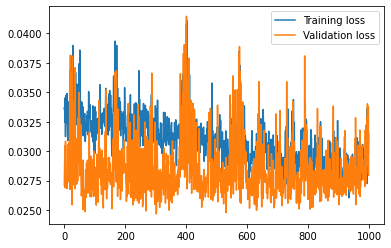

360/360 [==============================] - ETA: 1s - loss: 0.0222 - mean_absolute_error: 0.0222 - rmse: 0.03 - 0s 659us/sample - loss: 0.0286 - mean_absolute_error: 0.0286 - rmse: 0.0621
Score: [0.028570520712269676, 0.028570522, 0.06213235]


In [93]:
# Training and Validation loss curves
plt.plot(history.history['loss'], label = 'Training loss')
plt.plot(history.history['val_loss'], label = 'Validation loss')
plt.legend()
plt.show()

# Model evaluation with validation data
score = model.evaluate(np.reshape(xTest.values,(xTest.shape[0], xTest.shape[1], 1)), yTest)
print('Score:', score)

In [94]:
# Model training:
with tf.device('/gpu:0'): 

    # Create optimizer using Bayesian Optimization 
    tcnOptimizer = BayesianOptimization(build_model, 
                                objective = objective,
                                max_trials = trials, 
                                executions_per_trial = executions,
                                project_name = projectNameBO,
                                overwrite=True)
    
    # Search space summary
    tcnOptimizer.search_space_summary()

    # Search execution with epochs
    initialTime = time.time()
    tcnOptimizer.search(x = np.reshape(xTrain.values, (xTrain.shape[0], xTrain.shape[1], 1)),
                        y = yTrain, 
                        epochs = epchs,
                        batch_size = batch,
                        validation_data=(np.reshape(xVal.values, (xVal.shape[0], xVal.shape[1], 1)), yVal))
    finalTime = time.time()

    # Results summary
    tcnOptimizer.results_summary()

    # Get best model generated
    model = tcnOptimizer.get_best_models(num_models = numBestModels)[0]

    # Model training with epochs 
    history = model.fit(
                np.reshape(xTrain.values, (xTrain.shape[0], xTrain.shape[1], 1)),
                yTrain,
                epochs = epchs,
                batch_size = batch,
                validation_data=(np.reshape(xVal.values, (xVal.shape[0], xVal.shape[1], 1)), yVal))

    # Show model info
    print("Tiempo de entrenamiento (en segundos):\t"+str(finalTime - initialTime))
    print("Tiempo de entrenamiento (en horas):\t"+str((finalTime - initialTime)/3600))
    print(history.history.keys())
    print(model.history.history)
    print(model.history.params)

Summary: 
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn (TCN)                    (None, 32)                28128     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 7)                 231       
Total params: 28,359
Trainable params: 28,359
Non-trainable params: 0
_________________________________________________________________


Summary: 
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn (TCN)                    (None, 64)                185408    
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 7)                 455       
Total params: 185,863
Trainable params: 185,863
Non-trainable params: 0
_________________________________________________________________
Train on 251 samples, validate on 108 samples
Epoch 1/1000
251/251 [==============================] - 2s 7ms/sample - loss: 1.4840 - mean_absolute_error: 1.4840 - rmse: 1.9951 - val_loss: 1.6432 - val_mean_absolute_error: 1.6432 - val_rmse: 2.0654
Epoch 2/1000
251/251 [==============================] - 0s 87us/sample - loss: 1.5147 - mean_absolute_error: 1.5147 - rmse

Summary: 
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn (TCN)                    (None, 128)               296704    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 7)                 903       
Total params: 297,607
Trainable params: 297,607
Non-trainable params: 0
_________________________________________________________________
Train on 251 samples, validate on 108 samples
Epoch 1/1000
251/251 [==============================] - 2s 8ms/sample - loss: 4.9554 - mean_absolute_error: 4.9554 - rmse: 6.2471 - val_loss: 25.3602 - val_mean_absolute_error: 25.3602 - val_rmse: 26.6189
Epoch 2/1000
251/251 [==============================] - 0s 235us/sample - loss: 21.6600 - mean_absolute_error: 21.6600 

INFO:tensorflow:Oracle triggered exit


Summary: 
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn (TCN)                    (None, 128)               296704    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 7)                 903       
Total params: 297,607
Trainable params: 297,607
Non-trainable params: 0
_________________________________________________________________
Train on 251 samples, validate on 108 samples
Epoch 1/1000
251/251 [==============================] - 1s 5ms/sample - loss: 0.0164 - mean_absolute_error: 0.0164 - rmse: 0.0354 - val_loss: 0.0267 - val_mean_absolute_error: 0.0267 - val_rmse: 0.0745
Epoch 2/1000
251/251 [==============================] - 0s 247us/sample - loss: 0.0197 - mean_absolute_error: 0.0197 - rms

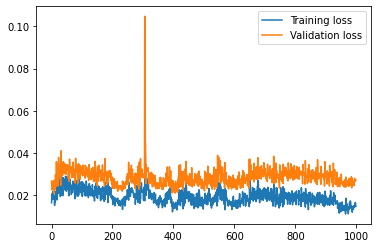

360/360 [==============================] - ETA: 0s - loss: 0.0204 - mean_absolute_error: 0.0204 - rmse: 0.03 - 0s 438us/sample - loss: 0.0259 - mean_absolute_error: 0.0259 - rmse: 0.0617
Score: [0.02585078047381507, 0.025850784, 0.061702587]


In [95]:
# Training and Validation loss curves
plt.plot(history.history['loss'], label = 'Training loss')
plt.plot(history.history['val_loss'], label = 'Validation loss')
plt.legend()
plt.show()

# Model evaluation with validation data
score = model.evaluate(np.reshape(xTest.values,(xTest.shape[0], xTest.shape[1], 1)), yTest)
print('Score:', score)